## prepare

In [3]:
import logging
import random
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import r2_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict
from datasets import concatenate_datasets, load_dataset
from sklearn.metrics import classification_report
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM
)


from sklearn.manifold import TSNE
from umap import UMAP
from tqdm.notebook import tqdm
from openai import OpenAI
from retry import retry
import itertools
from datasets import Dataset, DatasetDict

from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence
from torch.utils.tensorboard import SummaryWriter
import evaluate
import re
from sklearn.preprocessing import LabelEncoder
import pickle
import statistics
from matplotlib.lines import Line2D

logging.basicConfig(level=logging.INFO, format="%(name)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

# config
RANDOM_SEED = 0

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [4]:
def make_df_with_hidden_states_of_sentence(
    model, tokenizer, original_df,
):
    num_layers = model.config.num_hidden_layers+1 # emb+レイヤー数
    hidden_state_ans_per_layer_column = list()

    for _, row in original_df.iterrows():
        inputs = tokenizer(row['sentence'], return_tensors="pt").to(device)
        outputs = model(**inputs, output_hidden_states=True)
        hidden_state_per_layer = defaultdict()     
        for layer in range(num_layers):
            hidden_state_per_layer[layer] = outputs.hidden_states[layer][0, :, :].cpu().detach().numpy()
        hidden_state_ans_per_layer_column.append(hidden_state_per_layer)

    original_df['hidden_states_of_sentence'] = hidden_state_ans_per_layer_column
    
    return original_df

def calc_hs_of_token_position(hs, layer, token_position):
    hs_of_token_position = None
    if token_position == -1 or token_position== 0:
        hs_of_token_position = hs[layer][int(token_position)]
    elif 0 < token_position and token_position < 1:
        tp = round(len(hs[layer]) * token_position)
        hs_of_token_position = hs[layer][tp]
    elif token_position == 1:
        hs_of_token_position = hs[layer][-1]
        
    return hs_of_token_position

def apply_probe_to_hidden_states(
    layer_num, original_df_with_hs, eval_target, true_unk_df_with_hs=None, meta_reps_flag=False, query_flag=False, query_str=None, train_target_meta_reps=None, test_target_meta_reps=None, meta_position_flag=False,train_target_meta_positions=None, test_target_meta_positions=None,token_position=-1
):
    '''eval_target = ['all', 'all_true_unk','meta_tag', 'meta_tag_2', 'meta_tag_none', 'meta_reps', 'meta_positon']
    all: meta_tag and none
    all_true_unk: all and true_unk
    meta_tag: known, unknown, others
    meta_tag_2: known, unknown
    meta_tag_none: meta_tag(known, unknown, others), none
    meta_reps: all meta_reps(ignoring meta_tag) or any(you should use flag)
    meta_position: 
    '''

    if eval_target not in ["all", "all_true_unk", "meta_tag", "meta_tag_2", "meta_tag_none", "meta_reps", "meta_position", "none_true_unk"] and (meta_reps_flag == False and meta_position_flag == False):
            raise Exception(f'Wrong eval_target = {eval_target}')

    accuracy_list, f1_list, classification_report_list = list(), list(),list() # [layer's result, ...}

    accuracy_metric = evaluate.load("accuracy")
    f1_metric = evaluate.load("f1")

    df_with_hs = original_df_with_hs.copy()

    for layer in range(layer_num):

        X_train, X_test, y_train, y_test = list(), list(), list(), list()

        # make dataset
        if query_flag:
            df_with_hs = df_with_hs.query(query_str)

        if meta_reps_flag:
            target_train_df = df_with_hs.query('meta_rep in @train_target_meta_reps')
            target_test_df = df_with_hs.query('meta_rep in @test_target_meta_reps')

            X_train, y_train = target_train_df['hidden_states_of_sentence'].map(lambda l: l[layer][token_position]).tolist(), target_train_df['meta_tag'].tolist()
            X_test, y_test = target_train_df['hidden_states_of_sentence'].map(lambda l: l[layer][token_position]).tolist(), target_test_df['meta_tag'].tolist()
  
        elif meta_position_flag:
            target_train_df = df_with_hs.query('meta_position in @train_target_meta_positions')
            target_test_df = df_with_hs.query('meta_position in @test_target_meta_positions')

            X_train, y_train = target_train_df['hidden_states_of_sentence'].map(lambda l: l[layer][token_position]).tolist(), target_train_df['meta_tag'].tolist()
            X_test, y_test = target_test_df['hidden_states_of_sentence'].map(lambda l: l[layer][token_position]).tolist(), target_test_df['meta_tag'].tolist()

        else:
            if eval_target in ['all', 'all_true_unk', 'meta_tag', 'mata_tag_2', 'meta_reps', 'meta_tag_none', 'none_true_unk']:
                if eval_target == 'meta_reps':
                    target_df = df_with_hs
                    X = target_df['hidden_states_of_sentence'].map(lambda l: l[layer][token_position]).tolist()
                    y = target_df['meta_rep'].tolist()
                elif eval_target == 'meta_tag_none':
                    target_df = df_with_hs

                    # metaの件数をnoneに合わせる
                    none_count = target_df['meta_tag'].value_counts().get('none')
                    target_df['meta_or_none'] = target_df['meta_tag'].apply(lambda x: 'meta' if x != 'none' else x)
                    only_meta_df = target_df[target_df['meta_or_none'] == 'meta'].sample(n=none_count, random_state=0, replace=True)
                    target_df = pd.concat([target_df[target_df['meta_tag'] == 'none'], only_meta_df]).reset_index(drop=True)

                    X = target_df['hidden_states_of_sentence'].apply(calc_hs_of_token_position, layer=layer, token_position=token_position).tolist()
                    y = target_df['meta_or_none'].tolist()
                else:
                    if eval_target == 'all':
                        target_df = df_with_hs
                    elif eval_target == 'all_true_unk':
                        # true_unkの件数は常にmeta_tagの中で最小であるため、他のmeta_tagの件数を合わせる
                        true_unk_count = len(true_unk_df_with_hs)
                        true_unk_df_with_hs['meta_tag'] = 'true_unk'
                        target_df = true_unk_df_with_hs

                        uniques, counts = np.unique(df_with_hs['meta_tag'], return_counts=True)
                        unique_temp_df = pd.DataFrame()
                        for unique, count in zip(uniques, counts):
                            if count >= true_unk_count:
                                unique_temp_df = df_with_hs[df_with_hs['meta_tag'] == unique].sample(n=true_unk_count, random_state=0, replace=True)
                                target_df = pd.concat([target_df, unique_temp_df])
                            else:
                                raise Exception("meta-tag {unique}'s count {count} is under true_unk_count {true_unk_count}")
                    elif eval_target == 'none_true_unk':
                        # true_unkの件数は常にmeta_tagの中で最小であるため、他のmeta_tagの件数を合わせる
                        true_unk_count = len(true_unk_df_with_hs)
                        true_unk_df_with_hs['meta_tag'] = 'true_unk'

                        none_df = df_with_hs[df_with_hs['meta_tag'] == 'none'].sample(n=true_unk_count, random_state=0, replace=True)
                        target_df = pd.concat([true_unk_df_with_hs, none_df])

                    elif eval_target == 'meta_tag':
                        target_df = df_with_hs.query('meta_tag != "none"')
                    elif eval_target == 'meta_tag_2':
                        target_df = df_with_hs.query('meta_tag in ["known", "unknown"]')
                    
                    X = target_df['hidden_states_of_sentence'].apply(calc_hs_of_token_position, layer=layer, token_position=token_position).tolist()
                    y = target_df['meta_tag'].tolist()

                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

        # train prover
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        clf = LogisticRegression(max_iter=200)
        clf.fit(X_train_scaled, y_train)

        # eval
        unique_y = set(y_train)
        unique_y.discard(None)
        unique_y = list(unique_y)
        le = LabelEncoder()
        le.fit(unique_y)

        accuracy_test = accuracy_metric.compute(references=le.transform(y_test), predictions=le.transform(clf.predict(X_test_scaled)))
        f1_test = f1_metric.compute(references=le.transform(y_test), predictions=le.transform(clf.predict(X_test_scaled)), average='macro')
        classification_report_test = classification_report(y_test, clf.predict(X_test_scaled))

        accuracy_list.append(accuracy_test)
        f1_list.append(f1_test)
        classification_report_list.append(classification_report_test)

    return accuracy_list, f1_list, classification_report_list, clf

def apply_probe_cv_to_hidden_states(
    layer_num, original_df_with_hs, target_meta_position=False, meta_reps_flag=False, train_target_meta_reps_same_as_test=False, train_target_meta_reps_dict=None, test_target_meta_reps_dict=None,\
          meta_position_flag=False,train_target_meta_position_same_as_test=False, train_target_meta_positions=None, test_target_meta_positions=None,token_position=-1, fold_num=5
):
    '''
    設定の条件でknown, unknownの2値分類を行う

    train_target_meta_reps_dict={"known":["known_rep1", "known_rep2"], "unknown":["unknown_rep1", "unknown_rep2"]} #2種類ずつのリスト固定
    test_target_meta_reps_dict={"known":"known_rep", "unknown":"unknown_rep"} #1種類ずつ固定

    train_target_meta_positions=['head', 'middle'] #2種類固定
    test_target_meta_positions=['tail'] #1種類固定
    '''

    if (meta_reps_flag == False and meta_position_flag == False):
            raise Exception(f'Wrong flag')

    accuracy_list = list() # [layer's result, ...}
    accuracy_metric = evaluate.load("accuracy")
    df_with_hs = original_df_with_hs.copy()
    if target_meta_position != False:
        df_with_hs = df_with_hs.query('meta_position == @target_meta_position')

    for layer in range(layer_num):

        temp_accuracy_list = list()

        # make dataset
        if meta_reps_flag:
            test_target_meta_rep_known = test_target_meta_reps_dict["known"]
            test_target_meta_rep_unknown = test_target_meta_reps_dict["unknown"]

            for i in range(fold_num):
                X_train, X_test, y_train, y_test = list(), list(), list(), list()
                test_known_df = df_with_hs.query('meta_rep == @test_target_meta_rep_known')
                test_known_num = len(test_known_df)
                test_unknown_df = df_with_hs.query('meta_rep == @test_target_meta_rep_unknown')
                test_unknown_num = len(test_unknown_df)

                if train_target_meta_reps_same_as_test == True:
                    # target_test_dfのあまりがtarget_train_df
                    target_train_df = pd.concat([test_known_df[:round(test_known_num/5*i)],\
                                                test_known_df[round(test_known_num/5*(i+1)):],\
                                                test_unknown_df[:round(test_unknown_num/5*i)],\
                                                test_unknown_df[round(test_unknown_num/5*(i+1)):]]).sample(frac=1)
                    target_test_df = pd.concat([test_known_df[round(test_known_num/5*i):round(test_known_num/5*(i+1))],#前から5分割\
                                                test_unknown_df[round(test_unknown_num/5*i):round(test_unknown_num/5*(i+1))]]).sample(frac=1)
                else:
                    train_target_meta_reps_known = train_target_meta_reps_dict["known"]
                    train_target_meta_reps_unknown = train_target_meta_reps_dict["unknown"]
                    # target_train_dfの件数を上記と揃える
                    known_sampling_num = round(test_known_num/5*2)
                    unknown_sampling_num = round(test_unknown_num/5*2)

                    target_train_df = pd.concat([df_with_hs.query('meta_rep==@train_target_meta_reps_known[0]').sample(n=known_sampling_num),\
                                df_with_hs.query('meta_rep==@train_target_meta_reps_unknown[0]').sample(n=unknown_sampling_num),\
                                df_with_hs.query('meta_rep==@train_target_meta_reps_known[1]').sample(n=known_sampling_num),\
                                df_with_hs.query('meta_rep==@train_target_meta_reps_unknown[1]').sample(n=unknown_sampling_num)]).sample(frac=1)
                    target_test_df = pd.concat([test_known_df[round(test_known_num/5*i):round(test_known_num/5*(i+1))],#前から5分割\
                                                test_unknown_df[round(test_unknown_num/5*i):round(test_unknown_num/5*(i+1))]]).sample(frac=1)

                X_train, y_train = target_train_df['hidden_states_of_sentence'].map(lambda l: l[layer][token_position]).tolist(), target_train_df['meta_tag'].tolist()
                X_test, y_test = target_test_df['hidden_states_of_sentence'].map(lambda l: l[layer][token_position]).tolist(), target_test_df['meta_tag'].tolist()

                # train prover
                scaler = StandardScaler()
                X_train_scaled = scaler.fit_transform(X_train)
                X_test_scaled = scaler.transform(X_test)

                clf = LogisticRegression(max_iter=200)
                clf.fit(X_train_scaled, y_train)

                # eval
                unique_y = set(y_train)
                unique_y.discard(None)
                unique_y = list(unique_y)
                le = LabelEncoder()
                le.fit(unique_y)

                accuracy_test = accuracy_metric.compute(references=le.transform(y_test), predictions=le.transform(clf.predict(X_test_scaled)))
                temp_accuracy_list.append(accuracy_test['accuracy'])
            accuracy_list.append({'accuracy': round(statistics.mean(temp_accuracy_list), 3)})

  
        elif meta_position_flag:
            for i in range(fold_num):
                X_train, X_test, y_train, y_test = list(), list(), list(), list()
                test_known_df = df_with_hs.query('meta_position in @test_target_meta_positions and meta_tag=="known"')
                test_known_num = len(test_known_df)
                test_unknown_df = df_with_hs.query('meta_position in @test_target_meta_positions and meta_tag=="unknown"')
                test_unknown_num = len(test_unknown_df)

                if train_target_meta_position_same_as_test == True:
                    # target_test_dfのあまりがtarget_train_df
                    target_train_df = pd.concat([test_known_df[:round(test_known_num/5*i)],\
                                                test_known_df[round(test_known_num/5*(i+1)):],\
                                                test_unknown_df[:round(test_unknown_num/5*i)],\
                                                test_unknown_df[round(test_unknown_num/5*(i+1)):]]).sample(frac=1)
                    target_test_df = pd.concat([test_known_df[round(test_known_num/5*i):round(test_known_num/5*(i+1))],#前から5分割\
                                                test_unknown_df[round(test_unknown_num/5*i):round(test_unknown_num/5*(i+1))]]).sample(frac=1)
                else:
                    # target_train_dfの件数を上記と揃える
                    known_sampling_num = round(test_known_num/5*2)
                    unknown_sampling_num = round(test_unknown_num/5*2)

                    target_train_df = pd.concat([df_with_hs.query('meta_position==@train_target_meta_positions[0] and meta_tag=="known"').sample(n=known_sampling_num),\
                                df_with_hs.query('meta_position==@train_target_meta_positions[0] and meta_tag=="unknown"').sample(n=unknown_sampling_num),\
                                df_with_hs.query('meta_position==@train_target_meta_positions[1] and meta_tag=="known"').sample(n=known_sampling_num),\
                                df_with_hs.query('meta_position==@train_target_meta_positions[1] and meta_tag=="unknown"').sample(n=unknown_sampling_num)]).sample(frac=1)
                    target_test_df = pd.concat([test_known_df[round(test_known_num/5*i):round(test_known_num/5*(i+1))],#前から5分割\
                                                test_unknown_df[round(test_unknown_num/5*i):round(test_unknown_num/5*(i+1))]]).sample(frac=1)

                X_train, y_train = target_train_df['hidden_states_of_sentence'].map(lambda l: l[layer][token_position]).tolist(), target_train_df['meta_tag'].tolist()
                X_test, y_test = target_test_df['hidden_states_of_sentence'].map(lambda l: l[layer][token_position]).tolist(), target_test_df['meta_tag'].tolist()

                # train prover
                scaler = StandardScaler()
                X_train_scaled = scaler.fit_transform(X_train)
                X_test_scaled = scaler.transform(X_test)

                clf = LogisticRegression(max_iter=200)
                clf.fit(X_train_scaled, y_train)

                # eval
                unique_y = set(y_train)
                unique_y.discard(None)
                unique_y = list(unique_y)
                le = LabelEncoder()
                le.fit(unique_y)

                accuracy_test = accuracy_metric.compute(references=le.transform(y_test), predictions=le.transform(clf.predict(X_test_scaled)))
                temp_accuracy_list.append(accuracy_test['accuracy'])
            accuracy_list.append({'accuracy': round(statistics.mean(temp_accuracy_list), 3)})

    return accuracy_list, clf

def plot_score_layers(score_name_list, layer_list, score_dict, metrics_name, y_label, title, output_path, chance_rate=False, color_l=None):
    '''
    score_list = {'model_head': [{'accuracy': 0.66}, {'acc..}...], 'model_middle': [...]}
    or
    score_list = {''meta-tag+none': [{'accuracy': 0.66}, {'acc..}...], 'meta-tag': [...]}
    '''
    # Plot score values across layers with distinct styles for clarity
    plt.figure(figsize=(10, 6))
    linestyle_l = ["solid", "dashed", "dashdot", "dotted"]

    for i, score_name in enumerate(score_name_list):

        plt.plot(
            layer_list,
            [dic[metrics_name] for dic in score_dict[score_name]],
            linewidth=2,
            markersize=6,
            label=score_name,
            color=color_l[i]
        )

    if chance_rate:
        plt.axhline(y=chance_rate, color='gray', linestyle='dotted', linewidth=2, label='Chance Rate')
    plt.xlabel("Layer")
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    #plt.grid(True, linestyle='--', linewidth=0.5)
    plt.savefig(output_path)
    plt.show()

def plot_score_crosstest(layer_start, layer_end, accuracy_list_per_layer, y_label, title, output_path, chance_rate=False):
    # Plot score values across layers with distinct styles for clarity
    plt.figure(figsize=(15, 6))
    linestyle_l = ["solid", "dashed", "dashdot"]
    color_l = ['r','y','b']

    for layer in range(layer_start, layer_end+1):

        score_dict = accuracy_list_per_layer[layer]

        plt.plot(
            list(score_dict.keys()),
            [v[0] for v in score_dict.values()],
            #linestyle=linestyle_l[i],
            linewidth=2,
            markersize=6,
            label=f'layer {layer}'
        )
    if chance_rate:
        plt.axhline(y=chance_rate, color='gray', linestyle='dotted', linewidth=2, label='Chance Rate')
    
    plt.xlabel("hidden states")
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    #plt.grid(True, linestyle='--', linewidth=0.5)
    #plt.savefig(output_path)
    plt.show()

## RQ1

In [16]:
accuracy_list_dict_par_model = defaultdict(lambda: defaultdict(list))
setting_name_list = ['known-unknown', 'funny-boring','biased-unbiased']
base_model_names = ['Llama-3.2-1B', 'Llama-3.2-3B']
nums_hidden_layers = [16, 28]
meta_reps = [['known', 'unknown'], ['funny', 'boring'], ['biased', 'unbiased']]

In [ ]:
for base_model_name in base_model_names:
    for i, (meta_rep_known, meta_rep_unknown) in enumerate(meta_reps):
        setting_name = setting_name_list[i]

        model_name = f'{base_model_name}_3_mix_position_{meta_rep_known}_{meta_rep_unknown}'
        dd= load_dataset(f"kenken6696/ALCUNA_meta_affirmative_3_mix_position_{meta_rep_known}_{meta_rep_unknown}_train")['train'].train_test_split(test_size=0.2)

        tokenizer = AutoTokenizer.from_pretrained(f"kenken6696/{model_name}", trust_remote_code=True)
        model = AutoModelForCausalLM.from_pretrained(f"kenken6696/{model_name}", trust_remote_code=True, device_map='auto') # force_download=True

        df = make_df_with_hidden_states_of_sentence(model, tokenizer, pd.DataFrame(dd['train']))


        # prover
        score_name_list = ['meta_none', 'meta-tag']
        accuracy_list_dict= defaultdict(list)

        accuracy_list_dict[score_name_list[0]], _, _,_=  \
            apply_probe_to_hidden_states(layer_num=model.config.num_hidden_layers+1, original_df_with_hs=df, eval_target='meta_tag_none')
        accuracy_list_dict[score_name_list[1]], _, _,_=  \
            apply_probe_to_hidden_states(layer_num=model.config.num_hidden_layers+1, original_df_with_hs=df, eval_target='meta_tag')

        accuracy_list_dict_par_model[base_model_name][setting_name] = accuracy_list_dict

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# フィギュアの作成
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))  # 2つのサブプロットを作成

linestyle_l = ["dashed", "solid"]
color_l = ['b', 'g', 'm']
score_name_list_for_legend = ['meta_info', 'meta_rep']#['meta_none', 'meta-tag']

metrics_name = 'accuracy'

for bi, (ax, base_model_name) in enumerate(zip(axes, base_model_names)):
    # 1つ目の凡例（setting_name: 色ごと）
    setting_handles = []
    layer_list = range(nums_hidden_layers[bi] + 1)
    for mi, setting_name in enumerate(setting_name_list):
        setting_handles.append(Line2D([0], [0], color=color_l[mi], lw=2, label=setting_name))

    # 2つ目の凡例（score_name: ラインスタイルごと）
    score_handles = []
    for si, score_name in enumerate(score_name_list_for_legend):
        score_handles.append(Line2D([0], [0], color='black', linestyle=linestyle_l[si], lw=2, label=score_name))

    # プロット本体
    for mi, setting_name in enumerate(setting_name_list):
        for si, score_name in enumerate(score_name_list):
            ax.plot(
                layer_list,
                [dic[metrics_name] for dic in accuracy_list_dict_par_model[base_model_name][setting_name][score_name]],
                linewidth=2,
                markersize=6,
                color=color_l[mi],
                linestyle=linestyle_l[si]
            )

    # Chance Rate のライン
    ax.axhline(y=0.5, color='gray', linestyle='dotted', linewidth=2, label='Chance Rate')

    # 軸ラベル、タイトルの設定
    ax.set_xlabel("Layer", fontsize=14)
    ax.set_ylabel("Accuracy", fontsize=14)
    ax.set_title(f'{base_model_name}', fontsize=14)

    ax.set_ylim(0.4, 0.9)

    # 最初のサブプロットにのみ凡例を追加
    if bi == 0:
        legend1 = ax.legend(handles=setting_handles, loc='upper left', title="Model Settings")
        legend2 = ax.legend(handles=score_handles, loc='lower right', title="Score Type")
        ax.add_artist(legend1)  # 最初の凡例を固定
        ax.add_artist(legend2)  # 2つ目の凡例を追加

#plt.suptitle("知識文の隠れ状態を利用した学習設定の分類精度", fontsize=18)

# プロットの表示
plt.tight_layout()  # サブプロットが重ならないように調整
plt.savefig('/home/s2420422/metano2/result/eval/Llama-3.2_mix_rq1.png')
plt.show()

## RQ2

In [3]:
accuracy_list_dict_par_model = defaultdict(lambda: defaultdict(list)) 
setting_name_list = ['mix_syno', 'mix_same', 'head_syno', 'head_same', 'middle_syno', 'middle_same', 'tail_syno', 'tail_same']
probing_setting_list = ['synonym', 'same rep']
base_model_names = ['Llama-3.2-1B', 'Llama-3.2-3B']
ft_model_names = ['mix_position', 'fix_head', 'fix_middle', 'fix_tail']
nums_hidden_layers = [16, 28]


In [ ]:
meta_reps_known=['known', 'famous', 'understood']
meta_reps_unknown=['unknown', 'unrecognized', 'unfamiliar']
meta_reps_known_remain = copy.copy(meta_reps_known)
meta_reps_unknown_remain = copy.copy(meta_reps_unknown)
score_name_list = list()

for bi, base_model_name in enumerate(base_model_names):
    for fi, ft_model_name in enumerate(ft_model_names):

        temp_accuracy_list_dict = defaultdict(list)

        model_name = f'{base_model_name}_3x3_{ft_model_name}'
        dd= load_dataset(f"kenken6696/ALCUNA_meta_affirmative_3x3_for_{ft_model_name}_train")['train'].train_test_split(test_size=0.2)

        tokenizer = AutoTokenizer.from_pretrained(f"kenken6696/{model_name}", trust_remote_code=True)
        model = AutoModelForCausalLM.from_pretrained(f"kenken6696/{model_name}", trust_remote_code=True, device_map='auto') # force_download=True

        df = make_df_with_hidden_states_of_sentence(model, tokenizer, pd.DataFrame(dd['train']))
        
        for meta_rep_known in meta_reps_known:
            meta_reps_known_remain.remove(meta_rep_known)
            for meta_rep_unknown in meta_reps_unknown:
                meta_reps_unknown_remain.remove(meta_rep_unknown)
                print(f'---train:{meta_reps_known_remain, meta_reps_unknown_remain}\neval:{meta_rep_known, meta_rep_unknown}---')

                temp_accuracy_list_syno, _ = \
                    apply_probe_cv_to_hidden_states(layer_num=model.config.num_hidden_layers+1, original_df_with_hs=df, meta_reps_flag=True, \
                                            train_target_meta_reps_dict={"known":meta_reps_known_remain, "unknown":meta_reps_unknown_remain}, \
                                            test_target_meta_reps_dict={"known":meta_rep_known, "unknown":meta_rep_unknown})
                
                temp_accuracy_list_same, _ = \
                    apply_probe_cv_to_hidden_states(layer_num=model.config.num_hidden_layers+1, original_df_with_hs=df, meta_reps_flag=True, \
                                            train_target_meta_reps_same_as_test=True,\
                                            test_target_meta_reps_dict={"known":meta_rep_known, "unknown":meta_rep_unknown})       
                temp_accuracy_list_dict[probing_setting_list[0]].append(temp_accuracy_list_syno)
                temp_accuracy_list_dict[probing_setting_list[1]].append(temp_accuracy_list_same)

                meta_reps_unknown_remain = copy.copy(meta_reps_unknown)
            meta_reps_known_remain = copy.copy(meta_reps_known)

        
        syno_accuracy_list = [0] * (model.config.num_hidden_layers+1)
        same_accuracy_list = [0] * (model.config.num_hidden_layers+1)

        for layer in range(model.config.num_hidden_layers+1):
            # listからlayerごとに平均取って格納
            syno_acc_list = list()
            for accuracy_list in temp_accuracy_list_dict[probing_setting_list[0]]:
                syno_acc_list.append(accuracy_list[layer]['accuracy'])
            syno_accuracy_list[layer] = {'accuracy': round(statistics.mean(syno_acc_list), 3)}
            
            same_acc_list = list()
            for accuracy_list in temp_accuracy_list_dict[probing_setting_list[1]]:
                same_acc_list.append(accuracy_list[layer]['accuracy'])
            same_accuracy_list[layer] = {'accuracy': round(statistics.mean(same_acc_list), 3)}
        
        accuracy_list_dict_par_model[base_model_name][setting_name_list[fi*2]] = syno_accuracy_list
        accuracy_list_dict_par_model[base_model_name][setting_name_list[fi*2+1]] = same_accuracy_list


In [ ]:
import pickle

# defaultdict を dict に変換
accuracy_list_dict_par_model_forpkl = dict(accuracy_list_dict_par_model)

# 保存
with open('accuracy_list_dict_par_model.pkl', 'wb') as f:
    pickle.dump(accuracy_list_dict_par_model_forpkl, f)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# フィギュアの作成
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))  # 2つのサブプロットを作成

linestyle_l = ["solid", "dashed"]
color_l = ['b','g','m','r']
score_name_list_for_legend = ['synonym_rep_training', 'same_rep_training']
setting_name_for_legend = ['mix', 'head', 'middle', 'tail']

#setting_name_list = ['mix_syno', 'mix_same', 'head_syno', 'head_same', 'middle_syno', 'middle_same', 'tail_syno', 'tail_same']

metrics_name = 'accuracy'

for bi, (ax, base_model_name) in enumerate(zip(axes, base_model_names)):
    # 1つ目の凡例（setting_name: 色ごと）
    setting_handles = []
    layer_list = range(nums_hidden_layers[bi] + 1)
    for mi, setting_name in enumerate(setting_name_for_legend):
        setting_handles.append(Line2D([0], [0], color=color_l[mi], lw=2, label=setting_name))

    # 2つ目の凡例（score_name: ラインスタイルごと）
    score_handles = []
    for si, score_name in enumerate(score_name_list_for_legend):
        score_handles.append(Line2D([0], [0], color='black', linestyle=linestyle_l[si], lw=2, label=score_name))

    # プロット本体
    for li in range(4):#ft_model(mix, head, middle, tail)
        for c in range(2):#setting['synonym', 'same rep']
            setting_name = setting_name_list[li*2+c]
            ax.plot(
                layer_list,
                [dic[metrics_name] for dic in accuracy_list_dict_par_model[base_model_name][setting_name]],
                linewidth=2,
                markersize=6,
                color=color_l[li],
                linestyle=linestyle_l[c]
            )

    # Chance Rate のライン
    ax.axhline(y=0.5, color='gray', linestyle='dotted', linewidth=2, label='Chance Rate')

    # 軸ラベル、タイトルの設定
    ax.set_xlabel("Layer", fontsize=14)
    ax.set_ylabel("Accuracy", fontsize=14)
    ax.set_title(f'{base_model_name}', fontsize=14)

    ax.set_ylim(0.4, 0.9)

    # 最初のサブプロットにのみ凡例を追加
    if bi == 0:
        legend1 = ax.legend(handles=setting_handles, loc='upper left', title="Model Settings")
        legend2 = ax.legend(handles=score_handles, loc='lower right', title="Prober Setting")
        ax.add_artist(legend1)  # 最初の凡例を固定
        ax.add_artist(legend2)  # 2つ目の凡例を追加

#plt.suptitle("知識文の隠れ状態を利用した学習設定の分類精度", fontsize=18)

# プロットの表示
plt.tight_layout()  # サブプロットが重ならないように調整
plt.savefig('/home/s2420422/metano2/result/eval/Llama-3.2_mix_rq2.png')
plt.show()

## RQ3

In [25]:
accuracy_list_dict_par_model = defaultdict(lambda: defaultdict(list))
setting_name_list = ['head', 'middle','tail']
base_model_names = ['Llama-3.2-1B', 'Llama-3.2-3B']
nums_hidden_layers = [16, 28]
meta_reps = [['famous', 'unrecognized']]#[['understood', 'unfamiliar']]#[['famous', 'unrecognized']]#[['known', 'unknown']]

score_name_list = ['diffent_position-head', 'same_position-head', 'diffent_position-middle', 'same_position-middle','diffent_position-tail', 'same_position-tail']

In [26]:
for base_model_name in base_model_names:
    for i, (meta_rep_known, meta_rep_unknown) in enumerate(meta_reps):

        model_name = f'{base_model_name}_3_mix_position_{meta_rep_known}_{meta_rep_unknown}'
        dd= load_dataset(f"kenken6696/ALCUNA_meta_affirmative_3_mix_position_{meta_rep_known}_{meta_rep_unknown}_train")['train'].train_test_split(test_size=0.2)

        tokenizer = AutoTokenizer.from_pretrained(f"kenken6696/{model_name}", trust_remote_code=True)
        model = AutoModelForCausalLM.from_pretrained(f"kenken6696/{model_name}", trust_remote_code=True, device_map='auto') # force_download=True

        df = make_df_with_hidden_states_of_sentence(model, tokenizer, pd.DataFrame(dd['train']))


        # prover
        accuracy_list_dict= defaultdict(list)
        accuracy_list_dict[score_name_list[0]],_=  \
            apply_probe_cv_to_hidden_states(layer_num=model.config.num_hidden_layers+1, original_df_with_hs=df, meta_position_flag=True, train_target_meta_positions=['tail', 'middle'], test_target_meta_positions=['head'])
        accuracy_list_dict[score_name_list[1]],_=  \
            apply_probe_cv_to_hidden_states(layer_num=model.config.num_hidden_layers+1, original_df_with_hs=df, meta_position_flag=True, train_target_meta_position_same_as_test=True, test_target_meta_positions=['head'])
        accuracy_list_dict[score_name_list[2]],_=  \
            apply_probe_cv_to_hidden_states(layer_num=model.config.num_hidden_layers+1, original_df_with_hs=df, meta_position_flag=True, train_target_meta_positions=['head', 'tail'], test_target_meta_positions=['middle'])
        accuracy_list_dict[score_name_list[3]],_=  \
            apply_probe_cv_to_hidden_states(layer_num=model.config.num_hidden_layers+1, original_df_with_hs=df, meta_position_flag=True, train_target_meta_position_same_as_test=True, test_target_meta_positions=['middle'])
        accuracy_list_dict[score_name_list[4]],_=  \
            apply_probe_cv_to_hidden_states(layer_num=model.config.num_hidden_layers+1, original_df_with_hs=df, meta_position_flag=True, train_target_meta_positions=['head', 'middle'], test_target_meta_positions=['tail'])
        accuracy_list_dict[score_name_list[5]],_=  \
            apply_probe_cv_to_hidden_states(layer_num=model.config.num_hidden_layers+1, original_df_with_hs=df, meta_position_flag=True, train_target_meta_position_same_as_test=True, test_target_meta_positions=['tail'])
        accuracy_list_dict_par_model[base_model_name] = accuracy_list_dict

accelerate.utils.modeling - INFO - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

accelerate.big_modeling - WARNING - Some parameters are on the meta device because they were offloaded to the cpu.
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternativ

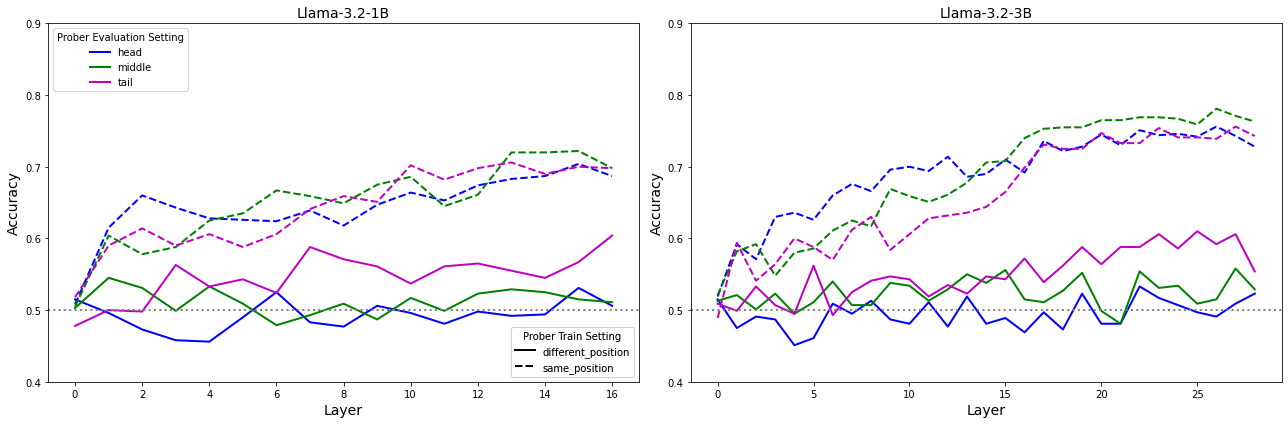

In [27]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# フィギュアの作成
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))  # 2つのサブプロットを作成

#score_name_list = ['diffent_position-tail', 'same_position-tail', 'diffent_position-head', 'same_position-head', 'diffent_position-middle', 'same_position-middle']
linestyle_l = ["solid", "dashed"]
color_l = ['b','g','m']
score_name_list_for_legend = ['different_position', 'same_position']
setting_name_for_legend = ['head', 'middle', 'tail']

metrics_name = 'accuracy'

for bi, (ax, base_model_name) in enumerate(zip(axes, base_model_names)):
    # 1つ目の凡例（setting_name: 色ごと）
    setting_handles = []
    layer_list = range(nums_hidden_layers[bi] + 1)
    for mi, setting_name in enumerate(setting_name_for_legend):
        setting_handles.append(Line2D([0], [0], color=color_l[mi], lw=2, label=setting_name))

    # 2つ目の凡例（score_name: ラインスタイルごと）
    score_handles = []
    for si, score_name in enumerate(score_name_list_for_legend):
        score_handles.append(Line2D([0], [0], color='black', linestyle=linestyle_l[si], lw=2, label=score_name))

    # プロット本体
    for li in range(3):#position
        for c in range(2):#setting(different-same)
            score_name = score_name_list[li*2+c]
            ax.plot(
                layer_list,
                [dic[metrics_name] for dic in accuracy_list_dict_par_model[base_model_name][score_name]],
                linewidth=2,
                markersize=6,
                color=color_l[li],
                linestyle=linestyle_l[c]
            )

    # Chance Rate のライン
    ax.axhline(y=0.5, color='gray', linestyle='dotted', linewidth=2, label='Chance Rate')

    # 軸ラベル、タイトルの設定
    ax.set_xlabel("Layer", fontsize=14)
    ax.set_ylabel("Accuracy", fontsize=14)
    ax.set_title(f'{base_model_name}', fontsize=14)

    ax.set_ylim(0.4, 0.9)

    # 最初のサブプロットにのみ凡例を追加
    if bi == 0:
        legend1 = ax.legend(handles=setting_handles, loc='upper left', title="Prober Evaluation Setting")
        legend2 = ax.legend(handles=score_handles, loc='lower right', title="Prober Train Setting")
        ax.add_artist(legend1)  # 最初の凡例を固定
        ax.add_artist(legend2)  # 2つ目の凡例を追加

#plt.suptitle("知識文の隠れ状態を利用した学習設定の分類精度", fontsize=18)

# プロットの表示
plt.tight_layout()  # サブプロットが重ならないように調整
plt.savefig(f'/home/s2420422/metano2/result/eval/Llama-3.2_mix_rq3_{meta_rep_known}_{meta_rep_unknown}.png')
plt.show()